In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma, kv
from numpy import matlib

import torch
import mgplvm as mgp
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
print(device)

from scipy.stats import poisson

loading
cuda


In [2]:
def matern_kernel(r, l, nu):
    """
    Matern kernel function
    """
    return (2**(1-nu)/gamma(nu))*((np.sqrt(2*nu)*r)/l)**nu*kv(nu, (np.sqrt(2*nu)*r)/l)

def squared_exponential_kernel(r, l):
    """
    Squared exponential kernel function
    """
    return np.exp(-(r**2)/(2*l**2))

def exponential_kernel(r, l):
    """
    Exponential kernel function
    """
    return np.exp(-r/l)

def matern_3_2_kernel(r, l):
    """
    Matern 3/2 kernel function
    """
    return (1+np.sqrt(3)*r/l)*np.exp(-np.sqrt(3)*r/l)


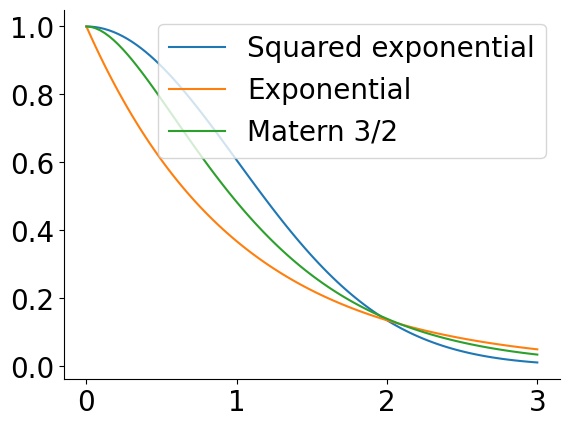

In [3]:
r = np.linspace(0, 3, 100)
l = 1.0
# nus = np.array([0.5, 1.5, 2.5])
plt.plot(r, squared_exponential_kernel(r, l), label='Squared exponential')
plt.plot(r, exponential_kernel(r, l), label='Exponential')
plt.plot(r, matern_3_2_kernel(r, l), label='Matern 3/2')
# for nu in nus:
#     plt.plot(r, matern_kernel(r, l, nu), label='Matern, nu={}'.format(nu))
plt.legend()
plt.show()

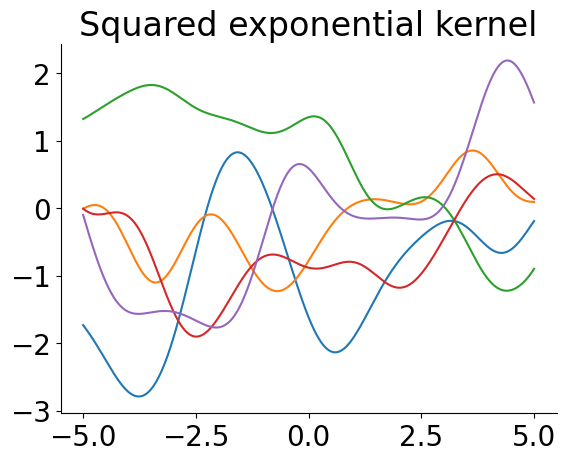

In [4]:
x_axis = np.linspace(-5, 5, 1000)
l = 1.0

K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
num_funcs = 5
plt.plot(x_axis, np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs).T)
plt.title('Squared exponential kernel')
plt.show()


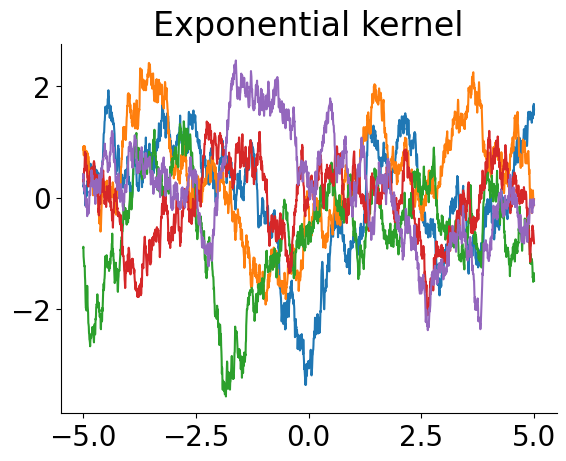

In [5]:
x_axis = np.linspace(-5, 5, 2000)
l = 1.0

K = exponential_kernel(abs(x_axis[:, None] - x_axis[None, :]), 1.0)
num_funcs = 5
plt.plot(x_axis, np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs).T)
plt.title('Exponential kernel')
plt.show()

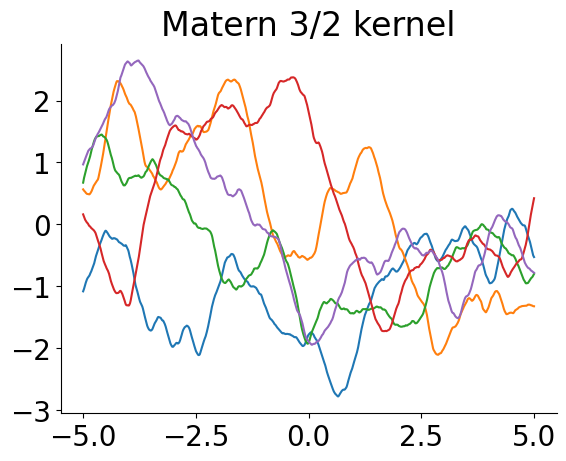

In [6]:
x_axis = np.linspace(-5, 5, 2000)
l = 1.0

K = matern_3_2_kernel(abs(x_axis[:, None] - x_axis[None, :]), 1.0)
num_funcs = 5
plt.plot(x_axis, np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs).T)
plt.title('Matern 3/2 kernel')
plt.show()

# Task

In [7]:
class SyntheticData:
    def __init__(self, dt=0.02, D=3, ntrials=1, l=0.2, start=0, stop=20, c_mean=0, c_var=1, N=100):
        self.dt = dt # time step (seconds)
        self.T = int((stop - start) / dt) # number of time steps

        self.D = D # number of latent dimensions
        self.ntrials = ntrials # number of trials

        if isinstance(l, float): # set length scale (in seconds) for each dimension
            self.l = np.array([l]*D)
            self._same_l = True
        else:
            self.l = np.array(l)
            self._same_l = False

        self.start = start # start time
        self.stop = stop # stop time
        self.c_mean = c_mean # mean of C
        self.c_var = c_var # variance of C
        self.N = N # number of neurons
        self.C = self.get_C() # N x D matrix
        self.x_axis = np.linspace(self.start, self.stop, self.T)

        self.Xs = []
        self.Ys = []

    def get_X(self, kernel): # return ntrials x D x T matrix
        if len(self.l) != self.D:
            raise ValueError("Length scale must be list of length D")

        X = np.zeros((self.ntrials, self.D, self.T))
        for i, l in enumerate(self.l):
            if kernel == 'squared_exponential':
                K = squared_exponential_kernel(self.x_axis[:, None] - self.x_axis[None, :], l)
            elif kernel == 'exponential':
                K = exponential_kernel(abs(self.x_axis[:, None] - self.x_axis[None, :]), l)
            elif kernel == 'matern_3_2':
                K = matern_3_2_kernel(abs(self.x_axis[:, None] - self.x_axis[None, :]), l)
            else:
                raise ValueError("Kernel Incorrect")
            
            if self._same_l: # This formulation is much faster but can only be done if all the length scales are the same
                X = np.random.multivariate_normal(mean=np.zeros(len(self.x_axis)), cov=K, size=(self.ntrials,self.D))
                break
            else:
                X[:,i,:] = np.random.multivariate_normal(mean=np.zeros(len(self.x_axis)), cov=K, size=(self.ntrials))
        
        self.Xs.append(X)
        return self.Xs[-1]

    def get_C(self): # returns N x D matrix
        return np.random.normal(self.c_mean, self.c_var, size=(self.N, self.D))

    def get_Y(self, kernel='squared_exponential'):
        X = self.get_X(kernel)
        F = np.matmul(self.C, X)
        self.Ys.append(np.random.poisson(np.log(1 + np.exp(F*self.dt))))
        return self.Ys[-1]

    def plot_Y(self, ind=None):
        ### plot the activity we just loaded ###
        for i, Y in enumerate(self.Ys):
            if ind is None or i == ind:
                plt.figure(figsize = (12, 6))
                plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
                plt.xlabel('time')
                plt.ylabel('neuron')
                plt.title('Raw activity', fontsize = 25)
                plt.xticks([])
                plt.yticks([])
                plt.show()

    def plot_X(self, ind=None):
        ### plot the activity we just loaded ###
        for i, X in enumerate(self.Xs):
            if ind is None or i == ind:
                X = X[0, ...] # take first trial
                for _X in X: # Loop through dimensions
                    plt.plot(self.x_axis, _X.T)
                plt.show()
    
    def training_setup(self, ind: int, rho, n_mc, print_every, max_steps, lrate):
        device = mgp.utils.get_device() # use GPU if available, otherwise CPU
        binsize = self.dt * 1000
        ts = np.arange(self.T)
        fit_ts = torch.tensor(ts)[None, None, :].to(device)
        Y = self.Ys[ind]
        data = torch.tensor(Y).to(device)
        
        ### set some parameters for fitting ###
        # aa2236 need to make this configurable
        # This needs to be of type float or int!!
        ell0 = float((self.l[0] * 1000)/binsize) # initial timescale (in bins) for each dimension. This could be the ~timescale of the behavior of interest (otherwise a few hundred ms is a reasonable default)

        if rho is None:
            rho = np.sqrt(self.c_var) # sets the intial scale of each latent (s_d in Jensen & Kao). rho=1 is a natural choice with Gaussian noise; less obvious with non-Gaussian noise but rho=1-5 works well empirically.
        else:
            rho = rho

        ### training will proceed for 1000 iterations (this takes ~2 minutes) ###
        t0 = time.time()
        def cb(mod, i, loss):
            """here we construct an (optional) function that helps us keep track of the training"""
            if i % print_every == 0:
                sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
                print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))
                print(loss.item(), mod.calc_LL(data = data, n_mc = n_mc).item())
                # # svgp_elbo, kl = mod.elbo(data, n_mc = n_mc, m=T, analytic_kl=True)
                # svgp_elbo, kl = mod(data, n_mc = n_mc, m=T, analytic_kl=True)
                # print(svgp_elbo.shape, kl.shape)
                # print('ELBO:', (svgp_elbo - kl).item())

        return Y, fit_ts, rho, ell0, device, data, cb
    
    def train(self, ind: int, nu: bool = False, rho=None, lrate=7.5e-2, max_steps=1001, n_mc=5, print_every=100, d_fit=10):
        Y, fit_ts, rho, ell0, device, data, cb = self.training_setup(ind, rho, n_mc, print_every, max_steps, lrate)

        ### construct the actual model ###
        ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
        # lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example (recommended for ephys data)
        lik = mgp.likelihoods.Poisson(n)
        manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space for bGPFA (see Jensen et al. 2020 for alternatives)
        var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = ell0) # circulant variational GP posterior (c.f. Jensen & Kao et al. 2021)
        lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
        mod = mgp.models.Lvgplvm(n, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = rho).to(device) #create bGPFA model with ARD

        # max_steps = 1001 # number of training iterations
        # n_mc = 5 # number of monte carlo samples per iteration
        # print_every = 100 # how often we print training progress


        # helper function to specify training parameters
        train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = lrate, callback = cb, print_every = np.nan)
        print('fitting', n, 'neurons and', T, 'time bins for', max_steps, 'iterations')
        mod_train = mgp.crossval.train_model(mod, data, train_ps)

            ### we start by plotting 'informative' and 'discarded' dimensions ###
        print('plotting informative and discarded dimensions')
        dim_scales = mod.obs.dim_scale.detach().cpu().numpy().flatten() #prior scales (s_d)
        dim_scales = np.log(dim_scales) #take the log of the prior scales
        plt.figure()
        if nu:
            nus = np.sqrt(np.mean(mod.lat_dist.nu.detach().cpu().numpy()**2, axis = (0, -1))) #magnitude of the variational means
            plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 80) #top right corner are informative, lower left discarded
            plt.ylabel(r'$||\nu||_2$', labelpad = 5)
        else:
            # nu is shape [n_trials, n_dims, n_times]
            # lat_mu is shape [n_trials, n_times, n_dims]
            lat_mu = mod.lat_dist.lat_mu.detach().cpu().numpy()
            mus = np.sqrt(np.mean(lat_mu**2, axis=(0, 1)))
            plt.scatter(dim_scales, mus, c = 'k', marker = 'x', s = 80)
            plt.ylabel(r'$||\mu||_2$', labelpad = 5)

        plt.xlabel(r'$\log \, s_d$')
        
        plt.show()
    
    def cross_validate(self, ind: int, nu: bool = False, rho=None, lrate=7.5e-2, max_steps=1001, n_mc=5, print_every=100, burnin=50, d_fit=10):
        Y, fit_ts, rho, ell0, device, _, cb = self.training_setup(ind, rho, n_mc, print_every, max_steps, lrate)
        train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, burnin = burnin, lrate = lrate, callback = cb)

        mod, split = mgp.crossval.train_cv_bgpfa(Y = Y, 
                                                 device=device,
                                                 train_ps=train_ps,
                                                 fit_ts=fit_ts,
                                                 d_fit=d_fit,
                                                 ell=ell0,
                                                 likelihood='Poisson',
                                                 nt_train=self.ntrials//2,
                                                 nn_train=self.N-1,
                                                 test=False)
        ### need to compute predictive likelihood ###

        Ycv, T1cv, N1cv = split['Y'], split['T1'], split['N1'] # all data, train data and train neurons
        m = self.T
        n = self.N
        T2cv, N2cv = mgp.crossval.not_in(np.arange(m), T1cv), mgp.crossval.not_in(np.arange(n), N1cv) # these are our testing timepoints and neurons

        Ytest = Ycv[:, N2cv, :][..., T2cv]  #test data (shape ntrial x N2 x T2)

        latents = mod.lat_dist.lat_mu.detach()[:, T2cv, ...] # extract test latent means (shape ntrial, T2, d)
        # construct input for prediction of neural activity
        query = latents.transpose(-1, -2).to(device)  #(ntrial, d, m)

        # predicted 'F'
        mu = mod.svgp.predict(query[None, ...], full_cov = False)[0]
        # mean of the implied distribution after transfer function (for test neurons)
        Ypred = mod.svgp.likelihood.dist_mean(mu)[0].detach()[:, N2cv, :]

        # compute log probability of actual test spike counts given test mean predictions
        LL = poisson.logpmf(Ytest, Ypred, loc=0)
        LL = np.mean(LL) # take avg

        # also compute MSEs
        MSE_vals = np.mean((Ypred - Ytest)**2, axis=(0, -1))
        MSE = np.mean(MSE_vals)  #standard MSE

        return LL, MSE

In [8]:
s = SyntheticData(c_var=5**2, D=5, stop=40, ntrials=1)

Y = s.get_Y()
print(np.shape(Y))

Y_e = s.get_Y(kernel='exponential')
print(np.shape(Y_e))

Y_matern_3_2 = s.get_Y(kernel='matern_3_2')
print(np.shape(Y_matern_3_2))

(1, 100, 2000)
(1, 100, 2000)
(1, 100, 2000)


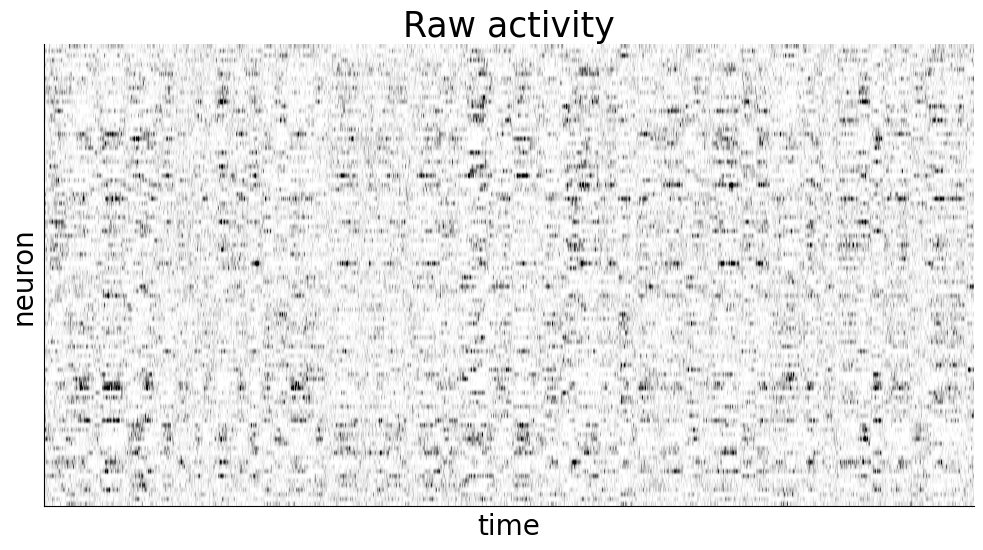

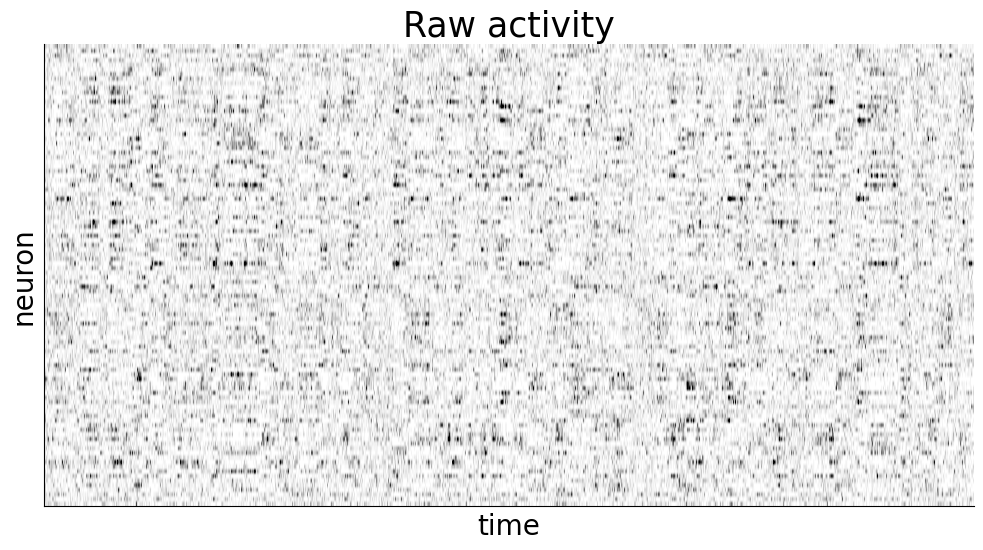

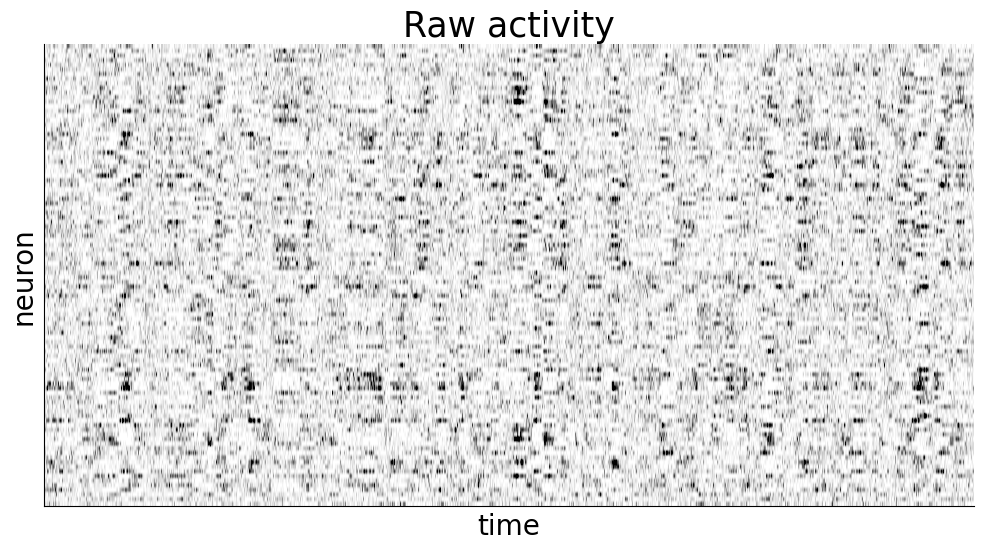

In [9]:
s.plot_Y()

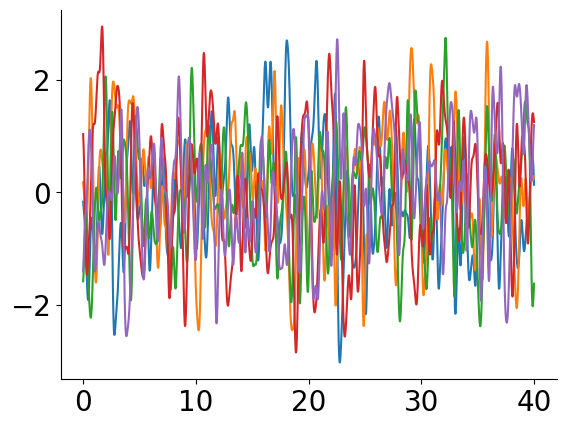

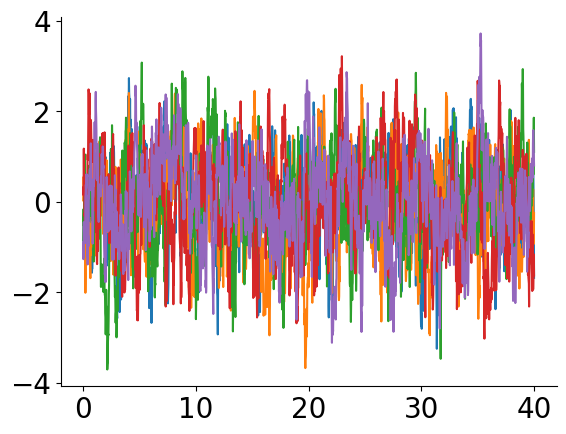

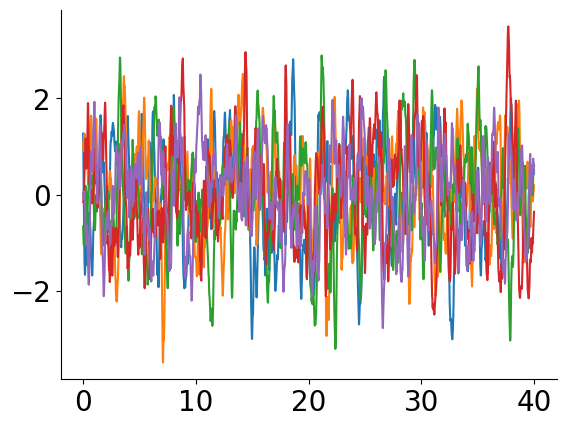

In [10]:
s.plot_X()

In [11]:
# s.cross_validate(0)

In [12]:
# '''
# What to do with binsize for synthetic data??
# '''

# def train(Y, nu=False):
#   binsize = s.dt * 1000
#   ts = np.arange(s.T)
#   fit_ts = torch.tensor(ts)[None, None, :].to(device)
#   data = torch.tensor(Y).to(device)

#   ### set some parameters for fitting ###
#   ell0 = (s.l * 1000)/binsize # initial timescale (in bins) for each dimension. This could be the ~timescale of the behavior of interest (otherwise a few hundred ms is a reasonable default)
#   rho = np.sqrt(s.c_var) # sets the intial scale of each latent (s_d in Jensen & Kao). rho=1 is a natural choice with Gaussian noise; less obvious with non-Gaussian noise but rho=1-5 works well empirically.
#   max_steps = 1001 # number of training iterations
#   n_mc = 5 # number of monte carlo samples per iteration
#   print_every = 100 # how often we print training progress
#   d_fit = 10 # lets fit up to 10 latent dimensions (in theory this could be up to the number of neurons; should be thought of as an upper bound to how high-dimensional the activity is)

#   ### construct the actual model ###
#   ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
#   # lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example (recommended for ephys data)
#   lik = mgp.likelihoods.Poisson(n)
#   manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space for bGPFA (see Jensen et al. 2020 for alternatives)
#   var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = ell0) # circulant variational GP posterior (c.f. Jensen & Kao et al. 2021)
#   lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
#   mod = mgp.models.Lvgplvm(n, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = rho).to(device) #create bGPFA model with ARD

#     ### training will proceed for 1000 iterations (this takes ~2 minutes) ###
#   t0 = time.time()
#   def cb(mod, i, loss):
#       """here we construct an (optional) function that helps us keep track of the training"""
#       if i % print_every == 0:
#           sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
#           print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))

#   # helper function to specify training parameters
#   train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 7.5e-2, callback = cb, print_every = np.nan)
#   print('fitting', n, 'neurons and', T, 'time bins for', max_steps, 'iterations')
#   mod_train = mgp.crossval.train_model(mod, data, train_ps)

#     ### we start by plotting 'informative' and 'discarded' dimensions ###
#   print('plotting informative and discarded dimensions')
#   dim_scales = mod.obs.dim_scale.detach().cpu().numpy().flatten() #prior scales (s_d)
#   dim_scales = np.log(dim_scales) #take the log of the prior scales
#   plt.figure()
#   if nu:
#     nus = np.sqrt(np.mean(mod.lat_dist.nu.detach().cpu().numpy()**2, axis = (0, -1))) #magnitude of the variational means
#     plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 80) #top right corner are informative, lower left discarded
#     plt.ylabel(r'$||\nu||_2$', labelpad = 5)
#   else:
#     # nu is shape [n_trials, n_dims, n_times]
#     # lat_mu is shape [n_trials, n_dims, n_times]
#     lat_mu = mod.lat_dist.lat_mu.detach().cpu().numpy()
#     mus = np.sqrt(np.mean(lat_mu**2, axis=(0, 1)))
#     plt.scatter(dim_scales, mus, c = 'k', marker = 'x', s = 80)
#     plt.ylabel(r'$||\mu||_2$', labelpad = 5)

#   plt.xlabel(r'$\log \, s_d$')
  
#   plt.show()


fitting 100 neurons and 2000 time bins for 1001 iterations
iter: 0 time: 0s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
7.667682168493687e+76 -3.412874279277405e+31
iter: 100 time: 4s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
1.5247311160796256e+37 -3.2342785688584915e+24
iter: 200 time: 8s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
7.311680178060993e+53 -6.957956672030951e+26
iter: 300 time: 12s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
4.4728226608211157e+46 -2.6638367894116855e+25
iter: 400 time: 16s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
7.721945119841712e+41 -3.968122729848689e+25
iter: 500 time: 19s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
4.502833569396661e+66 -1.921326798076329e+21
iter: 600 time: 23s log scales: [ 0.5  0.4  0.1  0.1 -0.3 -0.8 -1.1 -1.2 -1.3 -1.3]
1.027370844270865e+45 -5.850745362742987e+25
iter: 700 time: 27s log scales: [ 0.5  

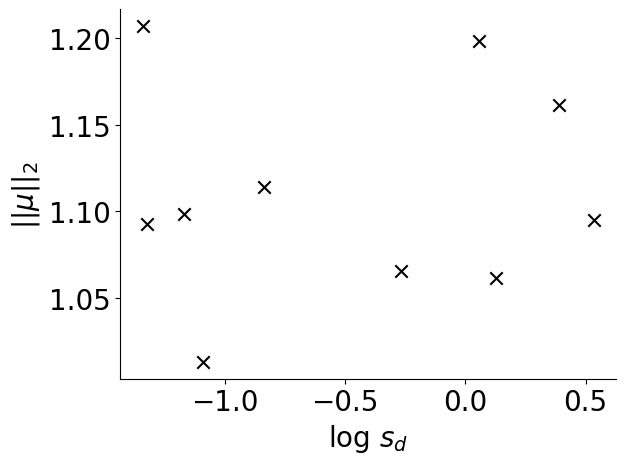

In [13]:
# train(Y)
# s.train(0, lrate=5e-4, max_steps=2001)
s.train(0)

fitting 100 neurons and 2000 time bins for 1001 iterations
iter: 0 time: 0s log scales: [ 0.4  0.4  0.3  0.  -0.1 -0.8 -1.1 -1.1 -1.3 -1.3]
9.404379246166031e+55 -8.578443284749781e+36
iter: 100 time: 4s log scales: [ 0.4  0.3  0.2 -0.  -0.2 -0.8 -1.1 -1.2 -1.3 -1.3]
1.0547197657015808e+50 -1.9702871652044084e+35
iter: 200 time: 8s log scales: [ 0.2 -0.2 -0.4 -1.  -1.3 -1.4 -1.6 -1.7 -1.9 -1.9]
9.157918148090505e+64 -1.46918956774416e+40
iter: 300 time: 12s log scales: [ 0.1 -0.3 -0.5 -1.  -1.6 -1.7 -1.7 -1.8 -1.9 -2. ]
3.0269715500358755e+63 -4.148904319087695e+52
iter: 400 time: 15s log scales: [ 0.  -0.3 -0.5 -1.  -1.7 -1.8 -1.9 -1.9 -1.9 -2. ]
3.454900106529675e+102 -1.0394615673266384e+66
iter: 500 time: 19s log scales: [ 0.  -0.3 -0.5 -1.  -1.7 -1.8 -1.9 -1.9 -1.9 -2. ]
3.651866147778321e+104 -4.43866217362575e+77
iter: 600 time: 23s log scales: [ 0.  -0.3 -0.5 -1.  -1.7 -1.8 -1.9 -1.9 -1.9 -2. ]
1.9838763040023257e+93 -6.157198518301467e+70
iter: 700 time: 27s log scales: [ 0.  

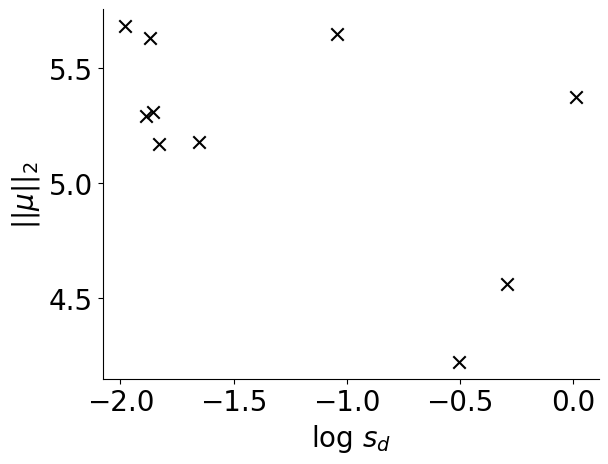

In [14]:
s.train(1)

fitting 100 neurons and 2000 time bins for 1001 iterations
iter: 0 time: 0s log scales: [ 0.5  0.3  0.2  0.1 -0.2 -0.7 -1.1 -1.2 -1.2 -1.3]
1.357804176426023e+77 -1.775411933116295e+33
iter: 100 time: 4s log scales: [ 0.5  0.2  0.1  0.  -0.2 -0.8 -1.1 -1.2 -1.3 -1.3]
5.890723751200535e+47 -4.9130568626352025e+32
iter: 200 time: 8s log scales: [ 0.3 -0.1 -0.3 -0.6 -0.7 -1.3 -1.5 -1.8 -2.  -2.1]
9.299325690410055e+88 -9.843220532805513e+52
iter: 300 time: 12s log scales: [ 0.4 -0.6 -0.7 -1.  -1.4 -2.  -2.1 -2.3 -2.6 -2.8]
1.3735511096781548e+76 -6.206263483986255e+61
iter: 400 time: 16s log scales: [ 0.4 -0.6 -0.7 -1.  -1.4 -2.  -2.1 -2.3 -2.6 -2.8]
2.862080632597281e+92 -1.244666541570453e+68
iter: 500 time: 19s log scales: [ 0.4 -0.6 -0.7 -1.  -1.4 -2.  -2.1 -2.3 -2.6 -2.8]
6.027235676937888e+95 -3.420757919686927e+61
iter: 600 time: 23s log scales: [ 0.4 -0.6 -0.7 -1.  -1.4 -2.  -2.1 -2.3 -2.6 -2.8]
2.2875386532618805e+78 -7.610251443445238e+61
iter: 700 time: 27s log scales: [ 0.4 -0

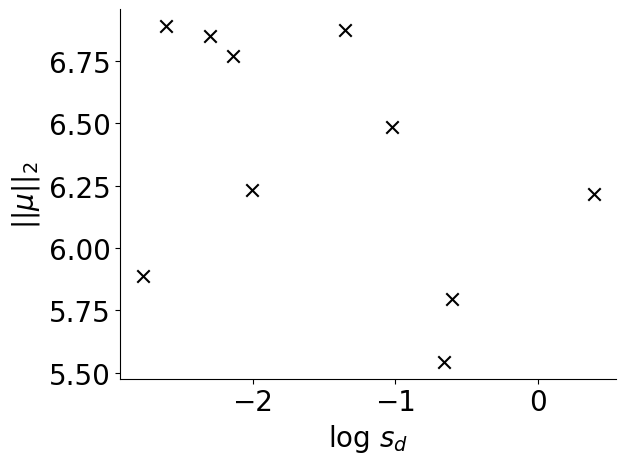

In [15]:
# train(Y_matern_3_2)

s.train(2)

In [16]:
rates = np.zeros(s.N)
for i in range(s.N):
    rates[i] = np.sum(s.Ys[0][0,i]) / s.stop
print(np.average(rates))
print(np.std(rates))

41.72
5.4077063067441085


In [17]:
a = 5
A = np.random.multivariate_normal(mean=np.zeros(a), cov=np.eye(a), size=(1,3))
A.shape
# np.matmul(np.eye(3), A) - A

(1, 3, 5)

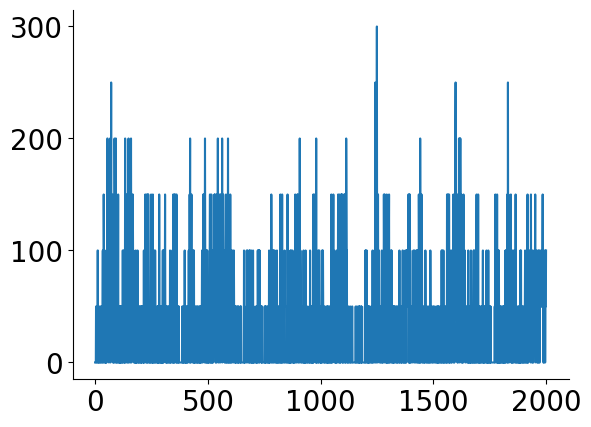

In [18]:
plt.plot(Y[0][0].T/s.dt)